## CNN
Welcome to second part of tutorial. <br>
CNNs are Convolutional Neural Networks, Due to limitations of MLP CNNs were born. <br>
I'm sure you guys already have looked at lectures. Now it's time to play. <br>
I would like to remind you. It's very important that you develop understanding of **MLP** and **CNNs** as they will be primary building blocks of DRL

In [4]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x) # convolution layer 1
        x = F.relu(x) # activation function
        x = self.conv2(x) # convolution layer 2
        x = F.relu(x) # activation function
        x = F.max_pool2d(x, 2) # polling layer
        x = self.dropout1(x) # drop out
        x = torch.flatten(x, 1) # flatten
        x = self.fc1(x) # fully connected
        x = F.relu(x) # activation function
        x = self.dropout2(x) # drop out
        x = self.fc2(x) # fully connected
        output = F.log_softmax(x, dim=1)  
        return output


def train(model, device, train_loader, optimizer, epoch, log_interval):
    """
    Function to train the model.
    
    Parameters
    ----------
    model: instance of model.
    
    device: GPU/CPU
        determined by pytorch if you have cuda installed. by default CPU
        
    train_loader: DataLoader
        instance to load training data, useful to form batches and do data transformation.
    
    optimiser: optimiser
    
    epoch: int
    
    log_interval: int
        the interval with which you want to log your metrices.
    
    Returns
    -------
    train_loss: float
    
    train_accuracy: float
    """
    model.train()
    correct = 0
    train_loss = list()
    train_accuracy = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy =100. * correct / len(train_loader.dataset)
            train_accuracy.append(accuracy)
            train_loss.append(loss.item())
            print('Train Epoch: {} [{}/{} ({:.0f}%)]'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader)))
    return train_loss, train_accuracy


def test(model, device, test_loader):
    """
    Function to test the model.
    
    Parameters
    ----------
    model: instance of model.
    
    device: GPU/CPU
        determined by pytorch if you have cuda installed. by default CPU
        
    test_loader: DataLoader
        instance to load testing data, useful to form batches and do data transformation.
    
    Returns
    -------
    test_loss: float
    
    test_accuracy: float
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return test_loss, accuracy


In [8]:
def main():
    # Training settings
    batch_size=64
    test_batch_size=1000
    epochs=10
    lr=0.2
    gamma=0.7
    no_cuda=False
    seed=1
    log_interval=1
    save_model=False
    test_loss_array = list()
    train_loss_array = list()
    test_accuracy_array = list()
    train_accuracy_array = list()
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)
    
    # set device for training (cpu/gpu)
    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    # wrap data in class and apply transformations
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)
    
    # declare model and copy it's instance to device
    model = Net().to(device)
    
    # declare optimiser.
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    # 
    for epoch in range(1, epochs + 1):
        train_loss , train_accuracy = train(model, device, train_loader, optimizer, epoch, log_interval)
        test_loss, test_accuracy = test(model, device, test_loader)
        test_loss_array.append(test_loss)
        test_accuracy_array.append(test_accuracy)
        train_loss_array.append(np.mean(train_loss))
        train_accuracy_array.append(np.mean(train_accuracy))
        scheduler.step()

    epoch_count = range(1, len(test_loss_array) + 1)
    # Visualize loss history
    plt.plot(epoch_count, test_loss_array, 'r--')
    plt.plot(epoch_count, train_loss_array, 'b-')
    plt.legend(['Test Loss', 'Train Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    
    plt.plot(epoch_count, test_accuracy_array, 'r--')
    plt.plot(epoch_count, train_accuracy_array, 'b-')
    plt.legend(['Test Accuracy', 'Train Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show();
    
    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]
Train Epoch: 1 [64/60000 (0%)]
Train Epoch: 1 [128/60000 (0%)]
Train Epoch: 1 [192/60000 (0%)]
Train Epoch: 1 [256/60000 (0%)]
Train Epoch: 1 [320/60000 (1%)]
Train Epoch: 1 [384/60000 (1%)]
Train Epoch: 1 [448/60000 (1%)]
Train Epoch: 1 [512/60000 (1%)]
Train Epoch: 1 [576/60000 (1%)]
Train Epoch: 1 [640/60000 (1%)]
Train Epoch: 1 [704/60000 (1%)]
Train Epoch: 1 [768/60000 (1%)]
Train Epoch: 1 [832/60000 (1%)]
Train Epoch: 1 [896/60000 (1%)]
Train Epoch: 1 [960/60000 (2%)]
Train Epoch: 1 [1024/60000 (2%)]
Train Epoch: 1 [1088/60000 (2%)]
Train Epoch: 1 [1152/60000 (2%)]
Train Epoch: 1 [1216/60000 (2%)]
Train Epoch: 1 [1280/60000 (2%)]
Train Epoch: 1 [1344/60000 (2%)]
Train Epoch: 1 [1408/60000 (2%)]
Train Epoch: 1 [1472/60000 (2%)]
Train Epoch: 1 [1536/60000 (3%)]
Train Epoch: 1 [1600/60000 (3%)]
Train Epoch: 1 [1664/60000 (3%)]
Train Epoch: 1 [1728/60000 (3%)]
Train Epoch: 1 [1792/60000 (3%)]
Train Epoch: 1 [1856/60000 (3%)]
Train Epoch: 1 [1920/60000 (3

Train Epoch: 1 [15552/60000 (26%)]
Train Epoch: 1 [15616/60000 (26%)]
Train Epoch: 1 [15680/60000 (26%)]
Train Epoch: 1 [15744/60000 (26%)]
Train Epoch: 1 [15808/60000 (26%)]
Train Epoch: 1 [15872/60000 (26%)]
Train Epoch: 1 [15936/60000 (27%)]
Train Epoch: 1 [16000/60000 (27%)]
Train Epoch: 1 [16064/60000 (27%)]
Train Epoch: 1 [16128/60000 (27%)]
Train Epoch: 1 [16192/60000 (27%)]
Train Epoch: 1 [16256/60000 (27%)]
Train Epoch: 1 [16320/60000 (27%)]
Train Epoch: 1 [16384/60000 (27%)]
Train Epoch: 1 [16448/60000 (27%)]
Train Epoch: 1 [16512/60000 (28%)]
Train Epoch: 1 [16576/60000 (28%)]
Train Epoch: 1 [16640/60000 (28%)]
Train Epoch: 1 [16704/60000 (28%)]
Train Epoch: 1 [16768/60000 (28%)]
Train Epoch: 1 [16832/60000 (28%)]
Train Epoch: 1 [16896/60000 (28%)]
Train Epoch: 1 [16960/60000 (28%)]
Train Epoch: 1 [17024/60000 (28%)]
Train Epoch: 1 [17088/60000 (28%)]
Train Epoch: 1 [17152/60000 (29%)]
Train Epoch: 1 [17216/60000 (29%)]
Train Epoch: 1 [17280/60000 (29%)]
Train Epoch: 1 [1734

Train Epoch: 1 [30592/60000 (51%)]
Train Epoch: 1 [30656/60000 (51%)]
Train Epoch: 1 [30720/60000 (51%)]
Train Epoch: 1 [30784/60000 (51%)]
Train Epoch: 1 [30848/60000 (51%)]
Train Epoch: 1 [30912/60000 (51%)]
Train Epoch: 1 [30976/60000 (52%)]
Train Epoch: 1 [31040/60000 (52%)]
Train Epoch: 1 [31104/60000 (52%)]
Train Epoch: 1 [31168/60000 (52%)]
Train Epoch: 1 [31232/60000 (52%)]
Train Epoch: 1 [31296/60000 (52%)]
Train Epoch: 1 [31360/60000 (52%)]
Train Epoch: 1 [31424/60000 (52%)]
Train Epoch: 1 [31488/60000 (52%)]
Train Epoch: 1 [31552/60000 (53%)]
Train Epoch: 1 [31616/60000 (53%)]
Train Epoch: 1 [31680/60000 (53%)]
Train Epoch: 1 [31744/60000 (53%)]
Train Epoch: 1 [31808/60000 (53%)]
Train Epoch: 1 [31872/60000 (53%)]
Train Epoch: 1 [31936/60000 (53%)]
Train Epoch: 1 [32000/60000 (53%)]
Train Epoch: 1 [32064/60000 (53%)]
Train Epoch: 1 [32128/60000 (54%)]
Train Epoch: 1 [32192/60000 (54%)]
Train Epoch: 1 [32256/60000 (54%)]
Train Epoch: 1 [32320/60000 (54%)]
Train Epoch: 1 [3238

Train Epoch: 1 [45632/60000 (76%)]
Train Epoch: 1 [45696/60000 (76%)]
Train Epoch: 1 [45760/60000 (76%)]
Train Epoch: 1 [45824/60000 (76%)]
Train Epoch: 1 [45888/60000 (76%)]
Train Epoch: 1 [45952/60000 (77%)]
Train Epoch: 1 [46016/60000 (77%)]
Train Epoch: 1 [46080/60000 (77%)]
Train Epoch: 1 [46144/60000 (77%)]
Train Epoch: 1 [46208/60000 (77%)]
Train Epoch: 1 [46272/60000 (77%)]
Train Epoch: 1 [46336/60000 (77%)]
Train Epoch: 1 [46400/60000 (77%)]
Train Epoch: 1 [46464/60000 (77%)]
Train Epoch: 1 [46528/60000 (78%)]
Train Epoch: 1 [46592/60000 (78%)]
Train Epoch: 1 [46656/60000 (78%)]
Train Epoch: 1 [46720/60000 (78%)]
Train Epoch: 1 [46784/60000 (78%)]
Train Epoch: 1 [46848/60000 (78%)]
Train Epoch: 1 [46912/60000 (78%)]
Train Epoch: 1 [46976/60000 (78%)]
Train Epoch: 1 [47040/60000 (78%)]
Train Epoch: 1 [47104/60000 (78%)]
Train Epoch: 1 [47168/60000 (79%)]
Train Epoch: 1 [47232/60000 (79%)]
Train Epoch: 1 [47296/60000 (79%)]
Train Epoch: 1 [47360/60000 (79%)]
Train Epoch: 1 [4742

Train Epoch: 2 [512/60000 (1%)]
Train Epoch: 2 [576/60000 (1%)]
Train Epoch: 2 [640/60000 (1%)]
Train Epoch: 2 [704/60000 (1%)]
Train Epoch: 2 [768/60000 (1%)]
Train Epoch: 2 [832/60000 (1%)]
Train Epoch: 2 [896/60000 (1%)]
Train Epoch: 2 [960/60000 (2%)]
Train Epoch: 2 [1024/60000 (2%)]
Train Epoch: 2 [1088/60000 (2%)]
Train Epoch: 2 [1152/60000 (2%)]
Train Epoch: 2 [1216/60000 (2%)]
Train Epoch: 2 [1280/60000 (2%)]
Train Epoch: 2 [1344/60000 (2%)]
Train Epoch: 2 [1408/60000 (2%)]
Train Epoch: 2 [1472/60000 (2%)]
Train Epoch: 2 [1536/60000 (3%)]
Train Epoch: 2 [1600/60000 (3%)]
Train Epoch: 2 [1664/60000 (3%)]
Train Epoch: 2 [1728/60000 (3%)]
Train Epoch: 2 [1792/60000 (3%)]
Train Epoch: 2 [1856/60000 (3%)]
Train Epoch: 2 [1920/60000 (3%)]
Train Epoch: 2 [1984/60000 (3%)]
Train Epoch: 2 [2048/60000 (3%)]
Train Epoch: 2 [2112/60000 (4%)]
Train Epoch: 2 [2176/60000 (4%)]
Train Epoch: 2 [2240/60000 (4%)]
Train Epoch: 2 [2304/60000 (4%)]
Train Epoch: 2 [2368/60000 (4%)]
Train Epoch: 2 [24

Train Epoch: 2 [16000/60000 (27%)]
Train Epoch: 2 [16064/60000 (27%)]
Train Epoch: 2 [16128/60000 (27%)]
Train Epoch: 2 [16192/60000 (27%)]
Train Epoch: 2 [16256/60000 (27%)]
Train Epoch: 2 [16320/60000 (27%)]
Train Epoch: 2 [16384/60000 (27%)]
Train Epoch: 2 [16448/60000 (27%)]
Train Epoch: 2 [16512/60000 (28%)]
Train Epoch: 2 [16576/60000 (28%)]
Train Epoch: 2 [16640/60000 (28%)]
Train Epoch: 2 [16704/60000 (28%)]
Train Epoch: 2 [16768/60000 (28%)]
Train Epoch: 2 [16832/60000 (28%)]
Train Epoch: 2 [16896/60000 (28%)]
Train Epoch: 2 [16960/60000 (28%)]
Train Epoch: 2 [17024/60000 (28%)]
Train Epoch: 2 [17088/60000 (28%)]
Train Epoch: 2 [17152/60000 (29%)]
Train Epoch: 2 [17216/60000 (29%)]
Train Epoch: 2 [17280/60000 (29%)]
Train Epoch: 2 [17344/60000 (29%)]
Train Epoch: 2 [17408/60000 (29%)]
Train Epoch: 2 [17472/60000 (29%)]
Train Epoch: 2 [17536/60000 (29%)]
Train Epoch: 2 [17600/60000 (29%)]
Train Epoch: 2 [17664/60000 (29%)]
Train Epoch: 2 [17728/60000 (30%)]
Train Epoch: 2 [1779

Train Epoch: 2 [31104/60000 (52%)]
Train Epoch: 2 [31168/60000 (52%)]
Train Epoch: 2 [31232/60000 (52%)]
Train Epoch: 2 [31296/60000 (52%)]
Train Epoch: 2 [31360/60000 (52%)]
Train Epoch: 2 [31424/60000 (52%)]
Train Epoch: 2 [31488/60000 (52%)]
Train Epoch: 2 [31552/60000 (53%)]
Train Epoch: 2 [31616/60000 (53%)]
Train Epoch: 2 [31680/60000 (53%)]
Train Epoch: 2 [31744/60000 (53%)]
Train Epoch: 2 [31808/60000 (53%)]
Train Epoch: 2 [31872/60000 (53%)]
Train Epoch: 2 [31936/60000 (53%)]
Train Epoch: 2 [32000/60000 (53%)]
Train Epoch: 2 [32064/60000 (53%)]
Train Epoch: 2 [32128/60000 (54%)]
Train Epoch: 2 [32192/60000 (54%)]
Train Epoch: 2 [32256/60000 (54%)]
Train Epoch: 2 [32320/60000 (54%)]
Train Epoch: 2 [32384/60000 (54%)]
Train Epoch: 2 [32448/60000 (54%)]
Train Epoch: 2 [32512/60000 (54%)]
Train Epoch: 2 [32576/60000 (54%)]
Train Epoch: 2 [32640/60000 (54%)]
Train Epoch: 2 [32704/60000 (54%)]
Train Epoch: 2 [32768/60000 (55%)]
Train Epoch: 2 [32832/60000 (55%)]
Train Epoch: 2 [3289

Train Epoch: 2 [46144/60000 (77%)]
Train Epoch: 2 [46208/60000 (77%)]
Train Epoch: 2 [46272/60000 (77%)]
Train Epoch: 2 [46336/60000 (77%)]
Train Epoch: 2 [46400/60000 (77%)]
Train Epoch: 2 [46464/60000 (77%)]
Train Epoch: 2 [46528/60000 (78%)]
Train Epoch: 2 [46592/60000 (78%)]
Train Epoch: 2 [46656/60000 (78%)]
Train Epoch: 2 [46720/60000 (78%)]
Train Epoch: 2 [46784/60000 (78%)]
Train Epoch: 2 [46848/60000 (78%)]
Train Epoch: 2 [46912/60000 (78%)]
Train Epoch: 2 [46976/60000 (78%)]
Train Epoch: 2 [47040/60000 (78%)]
Train Epoch: 2 [47104/60000 (78%)]
Train Epoch: 2 [47168/60000 (79%)]
Train Epoch: 2 [47232/60000 (79%)]
Train Epoch: 2 [47296/60000 (79%)]
Train Epoch: 2 [47360/60000 (79%)]
Train Epoch: 2 [47424/60000 (79%)]
Train Epoch: 2 [47488/60000 (79%)]
Train Epoch: 2 [47552/60000 (79%)]
Train Epoch: 2 [47616/60000 (79%)]
Train Epoch: 2 [47680/60000 (79%)]
Train Epoch: 2 [47744/60000 (80%)]
Train Epoch: 2 [47808/60000 (80%)]
Train Epoch: 2 [47872/60000 (80%)]
Train Epoch: 2 [4793

Train Epoch: 3 [1152/60000 (2%)]
Train Epoch: 3 [1216/60000 (2%)]
Train Epoch: 3 [1280/60000 (2%)]
Train Epoch: 3 [1344/60000 (2%)]
Train Epoch: 3 [1408/60000 (2%)]
Train Epoch: 3 [1472/60000 (2%)]
Train Epoch: 3 [1536/60000 (3%)]
Train Epoch: 3 [1600/60000 (3%)]
Train Epoch: 3 [1664/60000 (3%)]
Train Epoch: 3 [1728/60000 (3%)]
Train Epoch: 3 [1792/60000 (3%)]
Train Epoch: 3 [1856/60000 (3%)]
Train Epoch: 3 [1920/60000 (3%)]
Train Epoch: 3 [1984/60000 (3%)]
Train Epoch: 3 [2048/60000 (3%)]
Train Epoch: 3 [2112/60000 (4%)]
Train Epoch: 3 [2176/60000 (4%)]
Train Epoch: 3 [2240/60000 (4%)]
Train Epoch: 3 [2304/60000 (4%)]
Train Epoch: 3 [2368/60000 (4%)]
Train Epoch: 3 [2432/60000 (4%)]
Train Epoch: 3 [2496/60000 (4%)]
Train Epoch: 3 [2560/60000 (4%)]
Train Epoch: 3 [2624/60000 (4%)]
Train Epoch: 3 [2688/60000 (4%)]
Train Epoch: 3 [2752/60000 (5%)]
Train Epoch: 3 [2816/60000 (5%)]
Train Epoch: 3 [2880/60000 (5%)]
Train Epoch: 3 [2944/60000 (5%)]
Train Epoch: 3 [3008/60000 (5%)]
Train Epoc

Train Epoch: 3 [16704/60000 (28%)]
Train Epoch: 3 [16768/60000 (28%)]
Train Epoch: 3 [16832/60000 (28%)]
Train Epoch: 3 [16896/60000 (28%)]
Train Epoch: 3 [16960/60000 (28%)]
Train Epoch: 3 [17024/60000 (28%)]
Train Epoch: 3 [17088/60000 (28%)]
Train Epoch: 3 [17152/60000 (29%)]
Train Epoch: 3 [17216/60000 (29%)]
Train Epoch: 3 [17280/60000 (29%)]
Train Epoch: 3 [17344/60000 (29%)]
Train Epoch: 3 [17408/60000 (29%)]
Train Epoch: 3 [17472/60000 (29%)]
Train Epoch: 3 [17536/60000 (29%)]
Train Epoch: 3 [17600/60000 (29%)]
Train Epoch: 3 [17664/60000 (29%)]
Train Epoch: 3 [17728/60000 (30%)]
Train Epoch: 3 [17792/60000 (30%)]
Train Epoch: 3 [17856/60000 (30%)]
Train Epoch: 3 [17920/60000 (30%)]
Train Epoch: 3 [17984/60000 (30%)]
Train Epoch: 3 [18048/60000 (30%)]
Train Epoch: 3 [18112/60000 (30%)]
Train Epoch: 3 [18176/60000 (30%)]
Train Epoch: 3 [18240/60000 (30%)]
Train Epoch: 3 [18304/60000 (30%)]
Train Epoch: 3 [18368/60000 (31%)]
Train Epoch: 3 [18432/60000 (31%)]
Train Epoch: 3 [1849

Train Epoch: 3 [31744/60000 (53%)]
Train Epoch: 3 [31808/60000 (53%)]
Train Epoch: 3 [31872/60000 (53%)]
Train Epoch: 3 [31936/60000 (53%)]
Train Epoch: 3 [32000/60000 (53%)]
Train Epoch: 3 [32064/60000 (53%)]
Train Epoch: 3 [32128/60000 (54%)]
Train Epoch: 3 [32192/60000 (54%)]
Train Epoch: 3 [32256/60000 (54%)]
Train Epoch: 3 [32320/60000 (54%)]
Train Epoch: 3 [32384/60000 (54%)]
Train Epoch: 3 [32448/60000 (54%)]
Train Epoch: 3 [32512/60000 (54%)]
Train Epoch: 3 [32576/60000 (54%)]
Train Epoch: 3 [32640/60000 (54%)]
Train Epoch: 3 [32704/60000 (54%)]
Train Epoch: 3 [32768/60000 (55%)]
Train Epoch: 3 [32832/60000 (55%)]
Train Epoch: 3 [32896/60000 (55%)]
Train Epoch: 3 [32960/60000 (55%)]
Train Epoch: 3 [33024/60000 (55%)]
Train Epoch: 3 [33088/60000 (55%)]
Train Epoch: 3 [33152/60000 (55%)]
Train Epoch: 3 [33216/60000 (55%)]
Train Epoch: 3 [33280/60000 (55%)]
Train Epoch: 3 [33344/60000 (56%)]
Train Epoch: 3 [33408/60000 (56%)]
Train Epoch: 3 [33472/60000 (56%)]
Train Epoch: 3 [3353

Train Epoch: 3 [46848/60000 (78%)]
Train Epoch: 3 [46912/60000 (78%)]
Train Epoch: 3 [46976/60000 (78%)]
Train Epoch: 3 [47040/60000 (78%)]
Train Epoch: 3 [47104/60000 (78%)]
Train Epoch: 3 [47168/60000 (79%)]
Train Epoch: 3 [47232/60000 (79%)]
Train Epoch: 3 [47296/60000 (79%)]
Train Epoch: 3 [47360/60000 (79%)]
Train Epoch: 3 [47424/60000 (79%)]
Train Epoch: 3 [47488/60000 (79%)]
Train Epoch: 3 [47552/60000 (79%)]
Train Epoch: 3 [47616/60000 (79%)]
Train Epoch: 3 [47680/60000 (79%)]
Train Epoch: 3 [47744/60000 (80%)]
Train Epoch: 3 [47808/60000 (80%)]
Train Epoch: 3 [47872/60000 (80%)]
Train Epoch: 3 [47936/60000 (80%)]
Train Epoch: 3 [48000/60000 (80%)]
Train Epoch: 3 [48064/60000 (80%)]
Train Epoch: 3 [48128/60000 (80%)]
Train Epoch: 3 [48192/60000 (80%)]
Train Epoch: 3 [48256/60000 (80%)]
Train Epoch: 3 [48320/60000 (80%)]
Train Epoch: 3 [48384/60000 (81%)]
Train Epoch: 3 [48448/60000 (81%)]
Train Epoch: 3 [48512/60000 (81%)]
Train Epoch: 3 [48576/60000 (81%)]
Train Epoch: 3 [4864

Train Epoch: 4 [1856/60000 (3%)]
Train Epoch: 4 [1920/60000 (3%)]
Train Epoch: 4 [1984/60000 (3%)]
Train Epoch: 4 [2048/60000 (3%)]
Train Epoch: 4 [2112/60000 (4%)]
Train Epoch: 4 [2176/60000 (4%)]
Train Epoch: 4 [2240/60000 (4%)]
Train Epoch: 4 [2304/60000 (4%)]
Train Epoch: 4 [2368/60000 (4%)]
Train Epoch: 4 [2432/60000 (4%)]
Train Epoch: 4 [2496/60000 (4%)]
Train Epoch: 4 [2560/60000 (4%)]
Train Epoch: 4 [2624/60000 (4%)]
Train Epoch: 4 [2688/60000 (4%)]
Train Epoch: 4 [2752/60000 (5%)]
Train Epoch: 4 [2816/60000 (5%)]
Train Epoch: 4 [2880/60000 (5%)]
Train Epoch: 4 [2944/60000 (5%)]
Train Epoch: 4 [3008/60000 (5%)]
Train Epoch: 4 [3072/60000 (5%)]
Train Epoch: 4 [3136/60000 (5%)]
Train Epoch: 4 [3200/60000 (5%)]
Train Epoch: 4 [3264/60000 (5%)]
Train Epoch: 4 [3328/60000 (6%)]
Train Epoch: 4 [3392/60000 (6%)]
Train Epoch: 4 [3456/60000 (6%)]
Train Epoch: 4 [3520/60000 (6%)]
Train Epoch: 4 [3584/60000 (6%)]
Train Epoch: 4 [3648/60000 (6%)]
Train Epoch: 4 [3712/60000 (6%)]
Train Epoc

Train Epoch: 4 [17216/60000 (29%)]
Train Epoch: 4 [17280/60000 (29%)]
Train Epoch: 4 [17344/60000 (29%)]
Train Epoch: 4 [17408/60000 (29%)]
Train Epoch: 4 [17472/60000 (29%)]
Train Epoch: 4 [17536/60000 (29%)]
Train Epoch: 4 [17600/60000 (29%)]
Train Epoch: 4 [17664/60000 (29%)]
Train Epoch: 4 [17728/60000 (30%)]
Train Epoch: 4 [17792/60000 (30%)]
Train Epoch: 4 [17856/60000 (30%)]
Train Epoch: 4 [17920/60000 (30%)]
Train Epoch: 4 [17984/60000 (30%)]
Train Epoch: 4 [18048/60000 (30%)]
Train Epoch: 4 [18112/60000 (30%)]
Train Epoch: 4 [18176/60000 (30%)]
Train Epoch: 4 [18240/60000 (30%)]
Train Epoch: 4 [18304/60000 (30%)]
Train Epoch: 4 [18368/60000 (31%)]
Train Epoch: 4 [18432/60000 (31%)]
Train Epoch: 4 [18496/60000 (31%)]
Train Epoch: 4 [18560/60000 (31%)]
Train Epoch: 4 [18624/60000 (31%)]
Train Epoch: 4 [18688/60000 (31%)]
Train Epoch: 4 [18752/60000 (31%)]
Train Epoch: 4 [18816/60000 (31%)]
Train Epoch: 4 [18880/60000 (31%)]
Train Epoch: 4 [18944/60000 (32%)]
Train Epoch: 4 [1900

Train Epoch: 4 [32320/60000 (54%)]
Train Epoch: 4 [32384/60000 (54%)]
Train Epoch: 4 [32448/60000 (54%)]
Train Epoch: 4 [32512/60000 (54%)]
Train Epoch: 4 [32576/60000 (54%)]
Train Epoch: 4 [32640/60000 (54%)]
Train Epoch: 4 [32704/60000 (54%)]
Train Epoch: 4 [32768/60000 (55%)]
Train Epoch: 4 [32832/60000 (55%)]
Train Epoch: 4 [32896/60000 (55%)]
Train Epoch: 4 [32960/60000 (55%)]
Train Epoch: 4 [33024/60000 (55%)]
Train Epoch: 4 [33088/60000 (55%)]
Train Epoch: 4 [33152/60000 (55%)]
Train Epoch: 4 [33216/60000 (55%)]
Train Epoch: 4 [33280/60000 (55%)]
Train Epoch: 4 [33344/60000 (56%)]
Train Epoch: 4 [33408/60000 (56%)]
Train Epoch: 4 [33472/60000 (56%)]
Train Epoch: 4 [33536/60000 (56%)]
Train Epoch: 4 [33600/60000 (56%)]
Train Epoch: 4 [33664/60000 (56%)]
Train Epoch: 4 [33728/60000 (56%)]
Train Epoch: 4 [33792/60000 (56%)]
Train Epoch: 4 [33856/60000 (56%)]
Train Epoch: 4 [33920/60000 (57%)]
Train Epoch: 4 [33984/60000 (57%)]
Train Epoch: 4 [34048/60000 (57%)]
Train Epoch: 4 [3411

Train Epoch: 4 [47424/60000 (79%)]
Train Epoch: 4 [47488/60000 (79%)]
Train Epoch: 4 [47552/60000 (79%)]
Train Epoch: 4 [47616/60000 (79%)]
Train Epoch: 4 [47680/60000 (79%)]
Train Epoch: 4 [47744/60000 (80%)]
Train Epoch: 4 [47808/60000 (80%)]
Train Epoch: 4 [47872/60000 (80%)]
Train Epoch: 4 [47936/60000 (80%)]
Train Epoch: 4 [48000/60000 (80%)]
Train Epoch: 4 [48064/60000 (80%)]
Train Epoch: 4 [48128/60000 (80%)]
Train Epoch: 4 [48192/60000 (80%)]
Train Epoch: 4 [48256/60000 (80%)]
Train Epoch: 4 [48320/60000 (80%)]
Train Epoch: 4 [48384/60000 (81%)]
Train Epoch: 4 [48448/60000 (81%)]
Train Epoch: 4 [48512/60000 (81%)]
Train Epoch: 4 [48576/60000 (81%)]
Train Epoch: 4 [48640/60000 (81%)]
Train Epoch: 4 [48704/60000 (81%)]
Train Epoch: 4 [48768/60000 (81%)]
Train Epoch: 4 [48832/60000 (81%)]
Train Epoch: 4 [48896/60000 (81%)]
Train Epoch: 4 [48960/60000 (82%)]
Train Epoch: 4 [49024/60000 (82%)]
Train Epoch: 4 [49088/60000 (82%)]
Train Epoch: 4 [49152/60000 (82%)]
Train Epoch: 4 [4921

Train Epoch: 5 [2560/60000 (4%)]
Train Epoch: 5 [2624/60000 (4%)]
Train Epoch: 5 [2688/60000 (4%)]
Train Epoch: 5 [2752/60000 (5%)]
Train Epoch: 5 [2816/60000 (5%)]
Train Epoch: 5 [2880/60000 (5%)]
Train Epoch: 5 [2944/60000 (5%)]
Train Epoch: 5 [3008/60000 (5%)]
Train Epoch: 5 [3072/60000 (5%)]
Train Epoch: 5 [3136/60000 (5%)]
Train Epoch: 5 [3200/60000 (5%)]
Train Epoch: 5 [3264/60000 (5%)]
Train Epoch: 5 [3328/60000 (6%)]
Train Epoch: 5 [3392/60000 (6%)]
Train Epoch: 5 [3456/60000 (6%)]
Train Epoch: 5 [3520/60000 (6%)]
Train Epoch: 5 [3584/60000 (6%)]
Train Epoch: 5 [3648/60000 (6%)]
Train Epoch: 5 [3712/60000 (6%)]
Train Epoch: 5 [3776/60000 (6%)]
Train Epoch: 5 [3840/60000 (6%)]
Train Epoch: 5 [3904/60000 (7%)]
Train Epoch: 5 [3968/60000 (7%)]
Train Epoch: 5 [4032/60000 (7%)]
Train Epoch: 5 [4096/60000 (7%)]
Train Epoch: 5 [4160/60000 (7%)]
Train Epoch: 5 [4224/60000 (7%)]
Train Epoch: 5 [4288/60000 (7%)]
Train Epoch: 5 [4352/60000 (7%)]
Train Epoch: 5 [4416/60000 (7%)]
Train Epoc

Train Epoch: 5 [17920/60000 (30%)]
Train Epoch: 5 [17984/60000 (30%)]
Train Epoch: 5 [18048/60000 (30%)]
Train Epoch: 5 [18112/60000 (30%)]
Train Epoch: 5 [18176/60000 (30%)]
Train Epoch: 5 [18240/60000 (30%)]
Train Epoch: 5 [18304/60000 (30%)]
Train Epoch: 5 [18368/60000 (31%)]
Train Epoch: 5 [18432/60000 (31%)]
Train Epoch: 5 [18496/60000 (31%)]
Train Epoch: 5 [18560/60000 (31%)]
Train Epoch: 5 [18624/60000 (31%)]
Train Epoch: 5 [18688/60000 (31%)]
Train Epoch: 5 [18752/60000 (31%)]
Train Epoch: 5 [18816/60000 (31%)]
Train Epoch: 5 [18880/60000 (31%)]
Train Epoch: 5 [18944/60000 (32%)]
Train Epoch: 5 [19008/60000 (32%)]
Train Epoch: 5 [19072/60000 (32%)]
Train Epoch: 5 [19136/60000 (32%)]
Train Epoch: 5 [19200/60000 (32%)]
Train Epoch: 5 [19264/60000 (32%)]
Train Epoch: 5 [19328/60000 (32%)]
Train Epoch: 5 [19392/60000 (32%)]
Train Epoch: 5 [19456/60000 (32%)]
Train Epoch: 5 [19520/60000 (33%)]
Train Epoch: 5 [19584/60000 (33%)]
Train Epoch: 5 [19648/60000 (33%)]
Train Epoch: 5 [1971

Train Epoch: 5 [32960/60000 (55%)]
Train Epoch: 5 [33024/60000 (55%)]
Train Epoch: 5 [33088/60000 (55%)]
Train Epoch: 5 [33152/60000 (55%)]
Train Epoch: 5 [33216/60000 (55%)]
Train Epoch: 5 [33280/60000 (55%)]
Train Epoch: 5 [33344/60000 (56%)]
Train Epoch: 5 [33408/60000 (56%)]
Train Epoch: 5 [33472/60000 (56%)]
Train Epoch: 5 [33536/60000 (56%)]
Train Epoch: 5 [33600/60000 (56%)]
Train Epoch: 5 [33664/60000 (56%)]
Train Epoch: 5 [33728/60000 (56%)]
Train Epoch: 5 [33792/60000 (56%)]
Train Epoch: 5 [33856/60000 (56%)]
Train Epoch: 5 [33920/60000 (57%)]
Train Epoch: 5 [33984/60000 (57%)]
Train Epoch: 5 [34048/60000 (57%)]
Train Epoch: 5 [34112/60000 (57%)]
Train Epoch: 5 [34176/60000 (57%)]
Train Epoch: 5 [34240/60000 (57%)]
Train Epoch: 5 [34304/60000 (57%)]
Train Epoch: 5 [34368/60000 (57%)]
Train Epoch: 5 [34432/60000 (57%)]
Train Epoch: 5 [34496/60000 (57%)]
Train Epoch: 5 [34560/60000 (58%)]
Train Epoch: 5 [34624/60000 (58%)]
Train Epoch: 5 [34688/60000 (58%)]
Train Epoch: 5 [3475

Train Epoch: 5 [48000/60000 (80%)]
Train Epoch: 5 [48064/60000 (80%)]
Train Epoch: 5 [48128/60000 (80%)]
Train Epoch: 5 [48192/60000 (80%)]
Train Epoch: 5 [48256/60000 (80%)]
Train Epoch: 5 [48320/60000 (80%)]
Train Epoch: 5 [48384/60000 (81%)]
Train Epoch: 5 [48448/60000 (81%)]
Train Epoch: 5 [48512/60000 (81%)]
Train Epoch: 5 [48576/60000 (81%)]
Train Epoch: 5 [48640/60000 (81%)]
Train Epoch: 5 [48704/60000 (81%)]
Train Epoch: 5 [48768/60000 (81%)]
Train Epoch: 5 [48832/60000 (81%)]
Train Epoch: 5 [48896/60000 (81%)]
Train Epoch: 5 [48960/60000 (82%)]
Train Epoch: 5 [49024/60000 (82%)]
Train Epoch: 5 [49088/60000 (82%)]
Train Epoch: 5 [49152/60000 (82%)]
Train Epoch: 5 [49216/60000 (82%)]
Train Epoch: 5 [49280/60000 (82%)]
Train Epoch: 5 [49344/60000 (82%)]
Train Epoch: 5 [49408/60000 (82%)]
Train Epoch: 5 [49472/60000 (82%)]
Train Epoch: 5 [49536/60000 (83%)]
Train Epoch: 5 [49600/60000 (83%)]
Train Epoch: 5 [49664/60000 (83%)]
Train Epoch: 5 [49728/60000 (83%)]
Train Epoch: 5 [4979

Train Epoch: 6 [3072/60000 (5%)]
Train Epoch: 6 [3136/60000 (5%)]
Train Epoch: 6 [3200/60000 (5%)]
Train Epoch: 6 [3264/60000 (5%)]
Train Epoch: 6 [3328/60000 (6%)]
Train Epoch: 6 [3392/60000 (6%)]
Train Epoch: 6 [3456/60000 (6%)]
Train Epoch: 6 [3520/60000 (6%)]
Train Epoch: 6 [3584/60000 (6%)]
Train Epoch: 6 [3648/60000 (6%)]
Train Epoch: 6 [3712/60000 (6%)]
Train Epoch: 6 [3776/60000 (6%)]
Train Epoch: 6 [3840/60000 (6%)]
Train Epoch: 6 [3904/60000 (7%)]
Train Epoch: 6 [3968/60000 (7%)]
Train Epoch: 6 [4032/60000 (7%)]
Train Epoch: 6 [4096/60000 (7%)]
Train Epoch: 6 [4160/60000 (7%)]
Train Epoch: 6 [4224/60000 (7%)]
Train Epoch: 6 [4288/60000 (7%)]
Train Epoch: 6 [4352/60000 (7%)]
Train Epoch: 6 [4416/60000 (7%)]
Train Epoch: 6 [4480/60000 (7%)]
Train Epoch: 6 [4544/60000 (8%)]
Train Epoch: 6 [4608/60000 (8%)]
Train Epoch: 6 [4672/60000 (8%)]
Train Epoch: 6 [4736/60000 (8%)]
Train Epoch: 6 [4800/60000 (8%)]
Train Epoch: 6 [4864/60000 (8%)]
Train Epoch: 6 [4928/60000 (8%)]
Train Epoc

Train Epoch: 6 [18368/60000 (31%)]
Train Epoch: 6 [18432/60000 (31%)]
Train Epoch: 6 [18496/60000 (31%)]
Train Epoch: 6 [18560/60000 (31%)]
Train Epoch: 6 [18624/60000 (31%)]
Train Epoch: 6 [18688/60000 (31%)]
Train Epoch: 6 [18752/60000 (31%)]
Train Epoch: 6 [18816/60000 (31%)]
Train Epoch: 6 [18880/60000 (31%)]
Train Epoch: 6 [18944/60000 (32%)]
Train Epoch: 6 [19008/60000 (32%)]
Train Epoch: 6 [19072/60000 (32%)]
Train Epoch: 6 [19136/60000 (32%)]
Train Epoch: 6 [19200/60000 (32%)]
Train Epoch: 6 [19264/60000 (32%)]
Train Epoch: 6 [19328/60000 (32%)]
Train Epoch: 6 [19392/60000 (32%)]
Train Epoch: 6 [19456/60000 (32%)]
Train Epoch: 6 [19520/60000 (33%)]
Train Epoch: 6 [19584/60000 (33%)]
Train Epoch: 6 [19648/60000 (33%)]
Train Epoch: 6 [19712/60000 (33%)]
Train Epoch: 6 [19776/60000 (33%)]
Train Epoch: 6 [19840/60000 (33%)]
Train Epoch: 6 [19904/60000 (33%)]
Train Epoch: 6 [19968/60000 (33%)]
Train Epoch: 6 [20032/60000 (33%)]
Train Epoch: 6 [20096/60000 (33%)]
Train Epoch: 6 [2016

Train Epoch: 6 [33408/60000 (56%)]
Train Epoch: 6 [33472/60000 (56%)]
Train Epoch: 6 [33536/60000 (56%)]
Train Epoch: 6 [33600/60000 (56%)]
Train Epoch: 6 [33664/60000 (56%)]
Train Epoch: 6 [33728/60000 (56%)]
Train Epoch: 6 [33792/60000 (56%)]
Train Epoch: 6 [33856/60000 (56%)]
Train Epoch: 6 [33920/60000 (57%)]
Train Epoch: 6 [33984/60000 (57%)]
Train Epoch: 6 [34048/60000 (57%)]
Train Epoch: 6 [34112/60000 (57%)]
Train Epoch: 6 [34176/60000 (57%)]
Train Epoch: 6 [34240/60000 (57%)]
Train Epoch: 6 [34304/60000 (57%)]
Train Epoch: 6 [34368/60000 (57%)]
Train Epoch: 6 [34432/60000 (57%)]
Train Epoch: 6 [34496/60000 (57%)]
Train Epoch: 6 [34560/60000 (58%)]
Train Epoch: 6 [34624/60000 (58%)]
Train Epoch: 6 [34688/60000 (58%)]
Train Epoch: 6 [34752/60000 (58%)]
Train Epoch: 6 [34816/60000 (58%)]
Train Epoch: 6 [34880/60000 (58%)]
Train Epoch: 6 [34944/60000 (58%)]
Train Epoch: 6 [35008/60000 (58%)]
Train Epoch: 6 [35072/60000 (58%)]
Train Epoch: 6 [35136/60000 (59%)]
Train Epoch: 6 [3520

Train Epoch: 6 [48448/60000 (81%)]
Train Epoch: 6 [48512/60000 (81%)]
Train Epoch: 6 [48576/60000 (81%)]
Train Epoch: 6 [48640/60000 (81%)]
Train Epoch: 6 [48704/60000 (81%)]
Train Epoch: 6 [48768/60000 (81%)]
Train Epoch: 6 [48832/60000 (81%)]
Train Epoch: 6 [48896/60000 (81%)]
Train Epoch: 6 [48960/60000 (82%)]
Train Epoch: 6 [49024/60000 (82%)]
Train Epoch: 6 [49088/60000 (82%)]
Train Epoch: 6 [49152/60000 (82%)]
Train Epoch: 6 [49216/60000 (82%)]
Train Epoch: 6 [49280/60000 (82%)]
Train Epoch: 6 [49344/60000 (82%)]
Train Epoch: 6 [49408/60000 (82%)]
Train Epoch: 6 [49472/60000 (82%)]
Train Epoch: 6 [49536/60000 (83%)]
Train Epoch: 6 [49600/60000 (83%)]
Train Epoch: 6 [49664/60000 (83%)]
Train Epoch: 6 [49728/60000 (83%)]
Train Epoch: 6 [49792/60000 (83%)]
Train Epoch: 6 [49856/60000 (83%)]
Train Epoch: 6 [49920/60000 (83%)]
Train Epoch: 6 [49984/60000 (83%)]
Train Epoch: 6 [50048/60000 (83%)]
Train Epoch: 6 [50112/60000 (83%)]
Train Epoch: 6 [50176/60000 (84%)]
Train Epoch: 6 [5024

Train Epoch: 7 [3520/60000 (6%)]
Train Epoch: 7 [3584/60000 (6%)]
Train Epoch: 7 [3648/60000 (6%)]
Train Epoch: 7 [3712/60000 (6%)]
Train Epoch: 7 [3776/60000 (6%)]
Train Epoch: 7 [3840/60000 (6%)]
Train Epoch: 7 [3904/60000 (7%)]
Train Epoch: 7 [3968/60000 (7%)]
Train Epoch: 7 [4032/60000 (7%)]
Train Epoch: 7 [4096/60000 (7%)]
Train Epoch: 7 [4160/60000 (7%)]
Train Epoch: 7 [4224/60000 (7%)]
Train Epoch: 7 [4288/60000 (7%)]
Train Epoch: 7 [4352/60000 (7%)]
Train Epoch: 7 [4416/60000 (7%)]
Train Epoch: 7 [4480/60000 (7%)]
Train Epoch: 7 [4544/60000 (8%)]
Train Epoch: 7 [4608/60000 (8%)]
Train Epoch: 7 [4672/60000 (8%)]
Train Epoch: 7 [4736/60000 (8%)]
Train Epoch: 7 [4800/60000 (8%)]
Train Epoch: 7 [4864/60000 (8%)]
Train Epoch: 7 [4928/60000 (8%)]
Train Epoch: 7 [4992/60000 (8%)]
Train Epoch: 7 [5056/60000 (8%)]
Train Epoch: 7 [5120/60000 (9%)]
Train Epoch: 7 [5184/60000 (9%)]
Train Epoch: 7 [5248/60000 (9%)]
Train Epoch: 7 [5312/60000 (9%)]
Train Epoch: 7 [5376/60000 (9%)]
Train Epoc

Train Epoch: 7 [18880/60000 (31%)]
Train Epoch: 7 [18944/60000 (32%)]
Train Epoch: 7 [19008/60000 (32%)]
Train Epoch: 7 [19072/60000 (32%)]
Train Epoch: 7 [19136/60000 (32%)]
Train Epoch: 7 [19200/60000 (32%)]
Train Epoch: 7 [19264/60000 (32%)]
Train Epoch: 7 [19328/60000 (32%)]
Train Epoch: 7 [19392/60000 (32%)]
Train Epoch: 7 [19456/60000 (32%)]
Train Epoch: 7 [19520/60000 (33%)]
Train Epoch: 7 [19584/60000 (33%)]
Train Epoch: 7 [19648/60000 (33%)]
Train Epoch: 7 [19712/60000 (33%)]
Train Epoch: 7 [19776/60000 (33%)]
Train Epoch: 7 [19840/60000 (33%)]
Train Epoch: 7 [19904/60000 (33%)]
Train Epoch: 7 [19968/60000 (33%)]
Train Epoch: 7 [20032/60000 (33%)]
Train Epoch: 7 [20096/60000 (33%)]
Train Epoch: 7 [20160/60000 (34%)]
Train Epoch: 7 [20224/60000 (34%)]
Train Epoch: 7 [20288/60000 (34%)]
Train Epoch: 7 [20352/60000 (34%)]
Train Epoch: 7 [20416/60000 (34%)]
Train Epoch: 7 [20480/60000 (34%)]
Train Epoch: 7 [20544/60000 (34%)]
Train Epoch: 7 [20608/60000 (34%)]
Train Epoch: 7 [2067

Train Epoch: 7 [33984/60000 (57%)]
Train Epoch: 7 [34048/60000 (57%)]
Train Epoch: 7 [34112/60000 (57%)]
Train Epoch: 7 [34176/60000 (57%)]
Train Epoch: 7 [34240/60000 (57%)]
Train Epoch: 7 [34304/60000 (57%)]
Train Epoch: 7 [34368/60000 (57%)]
Train Epoch: 7 [34432/60000 (57%)]
Train Epoch: 7 [34496/60000 (57%)]
Train Epoch: 7 [34560/60000 (58%)]
Train Epoch: 7 [34624/60000 (58%)]
Train Epoch: 7 [34688/60000 (58%)]
Train Epoch: 7 [34752/60000 (58%)]
Train Epoch: 7 [34816/60000 (58%)]
Train Epoch: 7 [34880/60000 (58%)]
Train Epoch: 7 [34944/60000 (58%)]
Train Epoch: 7 [35008/60000 (58%)]
Train Epoch: 7 [35072/60000 (58%)]
Train Epoch: 7 [35136/60000 (59%)]
Train Epoch: 7 [35200/60000 (59%)]
Train Epoch: 7 [35264/60000 (59%)]
Train Epoch: 7 [35328/60000 (59%)]
Train Epoch: 7 [35392/60000 (59%)]
Train Epoch: 7 [35456/60000 (59%)]
Train Epoch: 7 [35520/60000 (59%)]
Train Epoch: 7 [35584/60000 (59%)]
Train Epoch: 7 [35648/60000 (59%)]
Train Epoch: 7 [35712/60000 (59%)]
Train Epoch: 7 [3577

Train Epoch: 7 [49024/60000 (82%)]
Train Epoch: 7 [49088/60000 (82%)]
Train Epoch: 7 [49152/60000 (82%)]
Train Epoch: 7 [49216/60000 (82%)]
Train Epoch: 7 [49280/60000 (82%)]
Train Epoch: 7 [49344/60000 (82%)]
Train Epoch: 7 [49408/60000 (82%)]
Train Epoch: 7 [49472/60000 (82%)]
Train Epoch: 7 [49536/60000 (83%)]
Train Epoch: 7 [49600/60000 (83%)]
Train Epoch: 7 [49664/60000 (83%)]
Train Epoch: 7 [49728/60000 (83%)]
Train Epoch: 7 [49792/60000 (83%)]
Train Epoch: 7 [49856/60000 (83%)]
Train Epoch: 7 [49920/60000 (83%)]
Train Epoch: 7 [49984/60000 (83%)]
Train Epoch: 7 [50048/60000 (83%)]
Train Epoch: 7 [50112/60000 (83%)]
Train Epoch: 7 [50176/60000 (84%)]
Train Epoch: 7 [50240/60000 (84%)]
Train Epoch: 7 [50304/60000 (84%)]
Train Epoch: 7 [50368/60000 (84%)]
Train Epoch: 7 [50432/60000 (84%)]
Train Epoch: 7 [50496/60000 (84%)]
Train Epoch: 7 [50560/60000 (84%)]
Train Epoch: 7 [50624/60000 (84%)]
Train Epoch: 7 [50688/60000 (84%)]
Train Epoch: 7 [50752/60000 (85%)]
Train Epoch: 7 [5081

Train Epoch: 8 [4224/60000 (7%)]
Train Epoch: 8 [4288/60000 (7%)]
Train Epoch: 8 [4352/60000 (7%)]
Train Epoch: 8 [4416/60000 (7%)]
Train Epoch: 8 [4480/60000 (7%)]
Train Epoch: 8 [4544/60000 (8%)]
Train Epoch: 8 [4608/60000 (8%)]
Train Epoch: 8 [4672/60000 (8%)]
Train Epoch: 8 [4736/60000 (8%)]
Train Epoch: 8 [4800/60000 (8%)]
Train Epoch: 8 [4864/60000 (8%)]
Train Epoch: 8 [4928/60000 (8%)]
Train Epoch: 8 [4992/60000 (8%)]
Train Epoch: 8 [5056/60000 (8%)]
Train Epoch: 8 [5120/60000 (9%)]
Train Epoch: 8 [5184/60000 (9%)]
Train Epoch: 8 [5248/60000 (9%)]
Train Epoch: 8 [5312/60000 (9%)]
Train Epoch: 8 [5376/60000 (9%)]
Train Epoch: 8 [5440/60000 (9%)]
Train Epoch: 8 [5504/60000 (9%)]
Train Epoch: 8 [5568/60000 (9%)]
Train Epoch: 8 [5632/60000 (9%)]
Train Epoch: 8 [5696/60000 (9%)]
Train Epoch: 8 [5760/60000 (10%)]
Train Epoch: 8 [5824/60000 (10%)]
Train Epoch: 8 [5888/60000 (10%)]
Train Epoch: 8 [5952/60000 (10%)]
Train Epoch: 8 [6016/60000 (10%)]
Train Epoch: 8 [6080/60000 (10%)]
Trai

Train Epoch: 8 [19520/60000 (33%)]
Train Epoch: 8 [19584/60000 (33%)]
Train Epoch: 8 [19648/60000 (33%)]
Train Epoch: 8 [19712/60000 (33%)]
Train Epoch: 8 [19776/60000 (33%)]
Train Epoch: 8 [19840/60000 (33%)]
Train Epoch: 8 [19904/60000 (33%)]
Train Epoch: 8 [19968/60000 (33%)]
Train Epoch: 8 [20032/60000 (33%)]
Train Epoch: 8 [20096/60000 (33%)]
Train Epoch: 8 [20160/60000 (34%)]
Train Epoch: 8 [20224/60000 (34%)]
Train Epoch: 8 [20288/60000 (34%)]
Train Epoch: 8 [20352/60000 (34%)]
Train Epoch: 8 [20416/60000 (34%)]
Train Epoch: 8 [20480/60000 (34%)]
Train Epoch: 8 [20544/60000 (34%)]
Train Epoch: 8 [20608/60000 (34%)]
Train Epoch: 8 [20672/60000 (34%)]
Train Epoch: 8 [20736/60000 (35%)]
Train Epoch: 8 [20800/60000 (35%)]
Train Epoch: 8 [20864/60000 (35%)]
Train Epoch: 8 [20928/60000 (35%)]
Train Epoch: 8 [20992/60000 (35%)]
Train Epoch: 8 [21056/60000 (35%)]
Train Epoch: 8 [21120/60000 (35%)]
Train Epoch: 8 [21184/60000 (35%)]
Train Epoch: 8 [21248/60000 (35%)]
Train Epoch: 8 [2131

Train Epoch: 8 [34624/60000 (58%)]
Train Epoch: 8 [34688/60000 (58%)]
Train Epoch: 8 [34752/60000 (58%)]
Train Epoch: 8 [34816/60000 (58%)]
Train Epoch: 8 [34880/60000 (58%)]
Train Epoch: 8 [34944/60000 (58%)]
Train Epoch: 8 [35008/60000 (58%)]
Train Epoch: 8 [35072/60000 (58%)]
Train Epoch: 8 [35136/60000 (59%)]
Train Epoch: 8 [35200/60000 (59%)]
Train Epoch: 8 [35264/60000 (59%)]
Train Epoch: 8 [35328/60000 (59%)]
Train Epoch: 8 [35392/60000 (59%)]
Train Epoch: 8 [35456/60000 (59%)]
Train Epoch: 8 [35520/60000 (59%)]
Train Epoch: 8 [35584/60000 (59%)]
Train Epoch: 8 [35648/60000 (59%)]
Train Epoch: 8 [35712/60000 (59%)]
Train Epoch: 8 [35776/60000 (60%)]
Train Epoch: 8 [35840/60000 (60%)]
Train Epoch: 8 [35904/60000 (60%)]
Train Epoch: 8 [35968/60000 (60%)]
Train Epoch: 8 [36032/60000 (60%)]
Train Epoch: 8 [36096/60000 (60%)]
Train Epoch: 8 [36160/60000 (60%)]
Train Epoch: 8 [36224/60000 (60%)]
Train Epoch: 8 [36288/60000 (60%)]
Train Epoch: 8 [36352/60000 (61%)]
Train Epoch: 8 [3641

Train Epoch: 8 [49728/60000 (83%)]
Train Epoch: 8 [49792/60000 (83%)]
Train Epoch: 8 [49856/60000 (83%)]
Train Epoch: 8 [49920/60000 (83%)]
Train Epoch: 8 [49984/60000 (83%)]
Train Epoch: 8 [50048/60000 (83%)]
Train Epoch: 8 [50112/60000 (83%)]
Train Epoch: 8 [50176/60000 (84%)]
Train Epoch: 8 [50240/60000 (84%)]
Train Epoch: 8 [50304/60000 (84%)]
Train Epoch: 8 [50368/60000 (84%)]
Train Epoch: 8 [50432/60000 (84%)]
Train Epoch: 8 [50496/60000 (84%)]
Train Epoch: 8 [50560/60000 (84%)]
Train Epoch: 8 [50624/60000 (84%)]
Train Epoch: 8 [50688/60000 (84%)]
Train Epoch: 8 [50752/60000 (85%)]
Train Epoch: 8 [50816/60000 (85%)]
Train Epoch: 8 [50880/60000 (85%)]
Train Epoch: 8 [50944/60000 (85%)]
Train Epoch: 8 [51008/60000 (85%)]
Train Epoch: 8 [51072/60000 (85%)]
Train Epoch: 8 [51136/60000 (85%)]
Train Epoch: 8 [51200/60000 (85%)]
Train Epoch: 8 [51264/60000 (85%)]
Train Epoch: 8 [51328/60000 (86%)]
Train Epoch: 8 [51392/60000 (86%)]
Train Epoch: 8 [51456/60000 (86%)]
Train Epoch: 8 [5152

Train Epoch: 9 [4928/60000 (8%)]
Train Epoch: 9 [4992/60000 (8%)]
Train Epoch: 9 [5056/60000 (8%)]
Train Epoch: 9 [5120/60000 (9%)]
Train Epoch: 9 [5184/60000 (9%)]
Train Epoch: 9 [5248/60000 (9%)]
Train Epoch: 9 [5312/60000 (9%)]
Train Epoch: 9 [5376/60000 (9%)]
Train Epoch: 9 [5440/60000 (9%)]
Train Epoch: 9 [5504/60000 (9%)]
Train Epoch: 9 [5568/60000 (9%)]
Train Epoch: 9 [5632/60000 (9%)]
Train Epoch: 9 [5696/60000 (9%)]
Train Epoch: 9 [5760/60000 (10%)]
Train Epoch: 9 [5824/60000 (10%)]
Train Epoch: 9 [5888/60000 (10%)]
Train Epoch: 9 [5952/60000 (10%)]
Train Epoch: 9 [6016/60000 (10%)]
Train Epoch: 9 [6080/60000 (10%)]
Train Epoch: 9 [6144/60000 (10%)]
Train Epoch: 9 [6208/60000 (10%)]
Train Epoch: 9 [6272/60000 (10%)]
Train Epoch: 9 [6336/60000 (11%)]
Train Epoch: 9 [6400/60000 (11%)]
Train Epoch: 9 [6464/60000 (11%)]
Train Epoch: 9 [6528/60000 (11%)]
Train Epoch: 9 [6592/60000 (11%)]
Train Epoch: 9 [6656/60000 (11%)]
Train Epoch: 9 [6720/60000 (11%)]
Train Epoch: 9 [6784/60000 

Train Epoch: 9 [20096/60000 (33%)]
Train Epoch: 9 [20160/60000 (34%)]
Train Epoch: 9 [20224/60000 (34%)]
Train Epoch: 9 [20288/60000 (34%)]
Train Epoch: 9 [20352/60000 (34%)]
Train Epoch: 9 [20416/60000 (34%)]
Train Epoch: 9 [20480/60000 (34%)]
Train Epoch: 9 [20544/60000 (34%)]
Train Epoch: 9 [20608/60000 (34%)]
Train Epoch: 9 [20672/60000 (34%)]
Train Epoch: 9 [20736/60000 (35%)]
Train Epoch: 9 [20800/60000 (35%)]
Train Epoch: 9 [20864/60000 (35%)]
Train Epoch: 9 [20928/60000 (35%)]
Train Epoch: 9 [20992/60000 (35%)]
Train Epoch: 9 [21056/60000 (35%)]
Train Epoch: 9 [21120/60000 (35%)]
Train Epoch: 9 [21184/60000 (35%)]
Train Epoch: 9 [21248/60000 (35%)]
Train Epoch: 9 [21312/60000 (36%)]
Train Epoch: 9 [21376/60000 (36%)]
Train Epoch: 9 [21440/60000 (36%)]
Train Epoch: 9 [21504/60000 (36%)]
Train Epoch: 9 [21568/60000 (36%)]
Train Epoch: 9 [21632/60000 (36%)]
Train Epoch: 9 [21696/60000 (36%)]
Train Epoch: 9 [21760/60000 (36%)]
Train Epoch: 9 [21824/60000 (36%)]
Train Epoch: 9 [2188

Train Epoch: 9 [35264/60000 (59%)]
Train Epoch: 9 [35328/60000 (59%)]
Train Epoch: 9 [35392/60000 (59%)]
Train Epoch: 9 [35456/60000 (59%)]
Train Epoch: 9 [35520/60000 (59%)]
Train Epoch: 9 [35584/60000 (59%)]
Train Epoch: 9 [35648/60000 (59%)]
Train Epoch: 9 [35712/60000 (59%)]
Train Epoch: 9 [35776/60000 (60%)]
Train Epoch: 9 [35840/60000 (60%)]
Train Epoch: 9 [35904/60000 (60%)]
Train Epoch: 9 [35968/60000 (60%)]
Train Epoch: 9 [36032/60000 (60%)]
Train Epoch: 9 [36096/60000 (60%)]
Train Epoch: 9 [36160/60000 (60%)]
Train Epoch: 9 [36224/60000 (60%)]
Train Epoch: 9 [36288/60000 (60%)]
Train Epoch: 9 [36352/60000 (61%)]
Train Epoch: 9 [36416/60000 (61%)]
Train Epoch: 9 [36480/60000 (61%)]
Train Epoch: 9 [36544/60000 (61%)]
Train Epoch: 9 [36608/60000 (61%)]
Train Epoch: 9 [36672/60000 (61%)]
Train Epoch: 9 [36736/60000 (61%)]
Train Epoch: 9 [36800/60000 (61%)]
Train Epoch: 9 [36864/60000 (61%)]
Train Epoch: 9 [36928/60000 (62%)]
Train Epoch: 9 [36992/60000 (62%)]
Train Epoch: 9 [3705

Train Epoch: 9 [50368/60000 (84%)]
Train Epoch: 9 [50432/60000 (84%)]
Train Epoch: 9 [50496/60000 (84%)]
Train Epoch: 9 [50560/60000 (84%)]
Train Epoch: 9 [50624/60000 (84%)]
Train Epoch: 9 [50688/60000 (84%)]
Train Epoch: 9 [50752/60000 (85%)]
Train Epoch: 9 [50816/60000 (85%)]
Train Epoch: 9 [50880/60000 (85%)]
Train Epoch: 9 [50944/60000 (85%)]
Train Epoch: 9 [51008/60000 (85%)]
Train Epoch: 9 [51072/60000 (85%)]
Train Epoch: 9 [51136/60000 (85%)]
Train Epoch: 9 [51200/60000 (85%)]
Train Epoch: 9 [51264/60000 (85%)]
Train Epoch: 9 [51328/60000 (86%)]
Train Epoch: 9 [51392/60000 (86%)]
Train Epoch: 9 [51456/60000 (86%)]
Train Epoch: 9 [51520/60000 (86%)]
Train Epoch: 9 [51584/60000 (86%)]
Train Epoch: 9 [51648/60000 (86%)]
Train Epoch: 9 [51712/60000 (86%)]
Train Epoch: 9 [51776/60000 (86%)]
Train Epoch: 9 [51840/60000 (86%)]
Train Epoch: 9 [51904/60000 (86%)]
Train Epoch: 9 [51968/60000 (87%)]
Train Epoch: 9 [52032/60000 (87%)]
Train Epoch: 9 [52096/60000 (87%)]
Train Epoch: 9 [5216

Train Epoch: 10 [5504/60000 (9%)]
Train Epoch: 10 [5568/60000 (9%)]
Train Epoch: 10 [5632/60000 (9%)]
Train Epoch: 10 [5696/60000 (9%)]
Train Epoch: 10 [5760/60000 (10%)]
Train Epoch: 10 [5824/60000 (10%)]
Train Epoch: 10 [5888/60000 (10%)]
Train Epoch: 10 [5952/60000 (10%)]
Train Epoch: 10 [6016/60000 (10%)]
Train Epoch: 10 [6080/60000 (10%)]
Train Epoch: 10 [6144/60000 (10%)]
Train Epoch: 10 [6208/60000 (10%)]
Train Epoch: 10 [6272/60000 (10%)]
Train Epoch: 10 [6336/60000 (11%)]
Train Epoch: 10 [6400/60000 (11%)]
Train Epoch: 10 [6464/60000 (11%)]
Train Epoch: 10 [6528/60000 (11%)]
Train Epoch: 10 [6592/60000 (11%)]
Train Epoch: 10 [6656/60000 (11%)]
Train Epoch: 10 [6720/60000 (11%)]
Train Epoch: 10 [6784/60000 (11%)]
Train Epoch: 10 [6848/60000 (11%)]
Train Epoch: 10 [6912/60000 (12%)]
Train Epoch: 10 [6976/60000 (12%)]
Train Epoch: 10 [7040/60000 (12%)]
Train Epoch: 10 [7104/60000 (12%)]
Train Epoch: 10 [7168/60000 (12%)]
Train Epoch: 10 [7232/60000 (12%)]
Train Epoch: 10 [7296/60

Train Epoch: 10 [20224/60000 (34%)]
Train Epoch: 10 [20288/60000 (34%)]
Train Epoch: 10 [20352/60000 (34%)]
Train Epoch: 10 [20416/60000 (34%)]
Train Epoch: 10 [20480/60000 (34%)]
Train Epoch: 10 [20544/60000 (34%)]
Train Epoch: 10 [20608/60000 (34%)]
Train Epoch: 10 [20672/60000 (34%)]
Train Epoch: 10 [20736/60000 (35%)]
Train Epoch: 10 [20800/60000 (35%)]
Train Epoch: 10 [20864/60000 (35%)]
Train Epoch: 10 [20928/60000 (35%)]
Train Epoch: 10 [20992/60000 (35%)]
Train Epoch: 10 [21056/60000 (35%)]
Train Epoch: 10 [21120/60000 (35%)]
Train Epoch: 10 [21184/60000 (35%)]
Train Epoch: 10 [21248/60000 (35%)]
Train Epoch: 10 [21312/60000 (36%)]
Train Epoch: 10 [21376/60000 (36%)]
Train Epoch: 10 [21440/60000 (36%)]
Train Epoch: 10 [21504/60000 (36%)]
Train Epoch: 10 [21568/60000 (36%)]
Train Epoch: 10 [21632/60000 (36%)]
Train Epoch: 10 [21696/60000 (36%)]
Train Epoch: 10 [21760/60000 (36%)]
Train Epoch: 10 [21824/60000 (36%)]
Train Epoch: 10 [21888/60000 (36%)]
Train Epoch: 10 [21952/60000

Train Epoch: 10 [34880/60000 (58%)]
Train Epoch: 10 [34944/60000 (58%)]
Train Epoch: 10 [35008/60000 (58%)]
Train Epoch: 10 [35072/60000 (58%)]
Train Epoch: 10 [35136/60000 (59%)]
Train Epoch: 10 [35200/60000 (59%)]
Train Epoch: 10 [35264/60000 (59%)]
Train Epoch: 10 [35328/60000 (59%)]
Train Epoch: 10 [35392/60000 (59%)]
Train Epoch: 10 [35456/60000 (59%)]
Train Epoch: 10 [35520/60000 (59%)]
Train Epoch: 10 [35584/60000 (59%)]
Train Epoch: 10 [35648/60000 (59%)]
Train Epoch: 10 [35712/60000 (59%)]
Train Epoch: 10 [35776/60000 (60%)]
Train Epoch: 10 [35840/60000 (60%)]
Train Epoch: 10 [35904/60000 (60%)]
Train Epoch: 10 [35968/60000 (60%)]
Train Epoch: 10 [36032/60000 (60%)]
Train Epoch: 10 [36096/60000 (60%)]
Train Epoch: 10 [36160/60000 (60%)]
Train Epoch: 10 [36224/60000 (60%)]
Train Epoch: 10 [36288/60000 (60%)]
Train Epoch: 10 [36352/60000 (61%)]
Train Epoch: 10 [36416/60000 (61%)]
Train Epoch: 10 [36480/60000 (61%)]
Train Epoch: 10 [36544/60000 (61%)]
Train Epoch: 10 [36608/60000

Train Epoch: 10 [49536/60000 (83%)]
Train Epoch: 10 [49600/60000 (83%)]
Train Epoch: 10 [49664/60000 (83%)]
Train Epoch: 10 [49728/60000 (83%)]
Train Epoch: 10 [49792/60000 (83%)]
Train Epoch: 10 [49856/60000 (83%)]
Train Epoch: 10 [49920/60000 (83%)]
Train Epoch: 10 [49984/60000 (83%)]
Train Epoch: 10 [50048/60000 (83%)]
Train Epoch: 10 [50112/60000 (83%)]
Train Epoch: 10 [50176/60000 (84%)]
Train Epoch: 10 [50240/60000 (84%)]
Train Epoch: 10 [50304/60000 (84%)]
Train Epoch: 10 [50368/60000 (84%)]
Train Epoch: 10 [50432/60000 (84%)]
Train Epoch: 10 [50496/60000 (84%)]
Train Epoch: 10 [50560/60000 (84%)]
Train Epoch: 10 [50624/60000 (84%)]
Train Epoch: 10 [50688/60000 (84%)]
Train Epoch: 10 [50752/60000 (85%)]
Train Epoch: 10 [50816/60000 (85%)]
Train Epoch: 10 [50880/60000 (85%)]
Train Epoch: 10 [50944/60000 (85%)]
Train Epoch: 10 [51008/60000 (85%)]
Train Epoch: 10 [51072/60000 (85%)]
Train Epoch: 10 [51136/60000 (85%)]
Train Epoch: 10 [51200/60000 (85%)]
Train Epoch: 10 [51264/60000

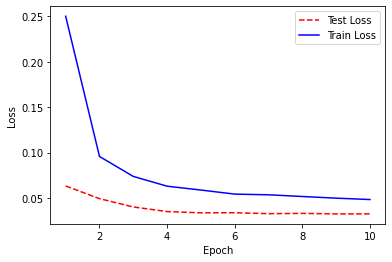

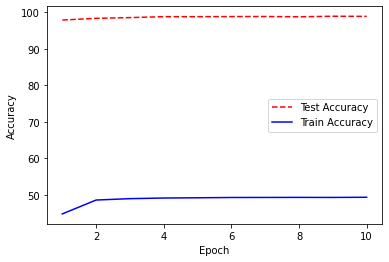

In [9]:
main()